# Vertex Extensions Staying in R(K<sub>m</sub>, J<sub>n</sub>)

Based on the vertex extension method in the [R(4,5) paper](https://www.cs.rit.edu/~spr/PUBL/paper32.pdf). This notebook will contain the function for extending a graph in R(K<sub>m</sub>, J<sub>n</sub>) by one vertex, while staying in R(K<sub>m</sub>, J<sub>n</sub>).

First, we define a class to represent Intervals as described on page 4 of the R(4,5) paper.

In [1]:
class Interval:
    
    # Construct a new interval with bottom_verts as the bottom and top_verts as the top
    def __init__(self, bottom_verts, top_verts):
        self.bottom = bottom_verts
        self.top = top_verts
        
    # Get interval as a string
    def __str__(self):
        as_string = "{"
        for vert in self.bottom:
            as_string += str(vert) + ","
        as_string += "}, {"
        for vert in self.top:
            as_string += str(vert) + ","
        as_string += "}"
        return as_string

We can now move on to the actual vertex extension function. This is based on the pseudocode given on page 9 of the R(4,5) paper.

In [16]:
import copy, itertools

# Finds all possible one vertex extensions to G while staying in R(Km,Jn), assumes G is already in R(Km,Jn)
# INPUT: a graph G to be extended, m the undesired clique size and n the undesired independent set (plus one edge) size
# OUTPUT: a set of intervals whose union forms every possible neighborhood of the new vertex
def find_extensions(G, m, n):
    
    # Helper function to find Kn-e
    def j_set_helper(G, n):
        j_list = list()
        potential_js = itertools.combinations(G.vertices(), n - 1)
        for j in potential_js:
            numEdges = 0
            for pair in itertools.combinations(j, 2):
                if G.has_edge(pair[0], pair[1]):
                    numEdges += 1
            if numEdges == 1:
                j_list.append(list(j))
        return j_list
        
    
    # Get cliques and independent sets of desired size
    clique_list = list(sage.graphs.cliquer.all_cliques(G, m - 1, m - 1))
    ind_set_list = list(sage.graphs.cliquer.all_cliques(G.complement(), n - 1, n - 1))
    j_set_list = j_set_helper(G, n)
    
#     print(clique_list)
#     print(ind_set_list)
#     print(j_set_list)

    # Merge clique_list, ind_set_list, and j_set_list and sort them by greatest element, as described in the R(4,5) paper
    all_sets_list = clique_list + ind_set_list + j_set_list
    # Function to reverse the individual sets
    # Note: We abuse the fact that the enumeration used to find the sets sorts the elements from smallest to greatest
    #       That way sorting them based on their reversed elements is the same as sorting by greatest element
    def reverseFunc(lst):
        return list(reversed(lst))
    all_sets_list.sort(key = reverseFunc)
    
    # Create initial interval
    viable_intervals = [Interval([],G.vertices())]
    
    # Iterate through the list of sets
    for group in all_sets_list:
        
        # If the set is a clique
        if group in clique_list:

            clique_as_set = set(group)
            new_intervals = viable_intervals.copy()

            for interval in viable_intervals:
                # Check if we need to worry about the current interval
                # Note that if this is false, one of the vertices from the clique 
                #   is never included in the neighborhoods corresponding to this interval
                if clique_as_set.issubset(interval.top):

                    # We always remove the given interval
                    new_intervals.remove(interval)
                    # Check if we need to find replacements
                    if not clique_as_set.issubset(interval.bottom):

                        # Find Xi - B
                        ys = []
                        for vert in group:
                            if not vert in interval.bottom:
                                ys.append(vert)

                        # Find replacement intervals and add them to the list
                        for j in range(0, len(ys)):
                            # Create copy of bottom and top
                            new_bottom = []
                            new_top = []
                            for vert in interval.bottom:
                                new_bottom.append(vert)
                            for vert in interval.top:
                                # Don't include yj into the top
                                if not vert == ys[j]:
                                    new_top.append(vert)
                            # Add y1,...,yj-1 elements to the bottom
                            for k in range(0, j):
                                new_bottom.append(ys[k])
                            # Add our new interval to the list
                            new_intervals.append(Interval(new_bottom, new_top))
            # Replace the old list of intervals with our new list of intervals
            viable_intervals = new_intervals


        # If the set is an independent set
        # This is a special case for R(Km,Jn) 
        if group in ind_set_list:

            ind_set_as_set = set(group)
            new_intervals = viable_intervals.copy()

            for interval in viable_intervals:
                # Check if we need to worry about the current interval
                # Note: We split this into two cases:
                #   - When the bottom and independent set don't intersect
                #      - We need to add at least two vertices from the independent set to the bottom
                #   - When there is exactly one vertex in the intersection of the bottom and independent set
                #      - We only need to add one additional vertex from the independent set to the bottom
                if len(ind_set_as_set & set(interval.bottom)) == 0:

                    # We always remove the given interval
                    new_intervals.remove(interval)
                    # Check if we need to find replacements
                    if len(ind_set_as_set & set(interval.top)) >= 2:
                        # Find Xi intersect T
                        ys = []
                        for vert in group:
                            if vert in interval.top:
                                ys.append(vert)

                        # Take every pair of vertices from the independent set
                        y_pairs = itertools.combinations(range(0,len(ys)), 2)
                        # Find replacement intervals and add them to the list
                        for pair in y_pairs:
                            # Create copies of bottom and top
                            new_bottom = []
                            new_top = []
                            for vert in interval.bottom:
                                new_bottom.append(vert)
                            # Add pair to bottom
                            new_bottom.append(ys[pair[0]])
                            new_bottom.append(ys[pair[1]])
                            for vert in interval.top:
                                new_top.append(vert)
                            # Remove all vertices in the independent set up to (and in between) the current pair from the top
                            for k in range(0, pair[0]):
                                new_top.remove(ys[k])
                            for k in range(pair[0]+1, pair[1]):
                                new_top.remove(ys[k])
                            new_intervals.append(Interval(new_bottom, new_top))


                elif len(ind_set_as_set & set(interval.bottom)) == 1:
                    # We always remove the given interval
                    new_intervals.remove(interval)
                    # Check if we need to find replacements
                    if len(ind_set_as_set & set(interval.top)) >= 2:
                        # Find Xi intersect T (but not the vertex already in the bottom)
                        ys = []
                        for vert in group:
                            if vert in interval.top and not vert in interval.bottom:
                                ys.append(vert)

                        # Find replacement intervals and add them to the list
                        for j in range(0,len(ys)):
                            # Create copies of bottom and top
                            new_bottom = []
                            new_top = []
                            for vert in interval.bottom:
                                new_bottom.append(vert)
                            # Add yj to bottom
                            new_bottom.append(ys[j])
                            for vert in interval.top:
                                new_top.append(vert)
                            # Remove all vertices up to yj from the top
                            for k in range(0, j):
                                new_top.remove(ys[k])
                            new_intervals.append(Interval(new_bottom, new_top))

            # Replace the old list of intervals with the new list of intervals
            viable_intervals = new_intervals



        # If the set is a J
        # Same logic as for independent sets in the Km,Kn case
        if group in j_set_list:

            j_set_as_set = set(group)
            new_intervals = viable_intervals.copy()

            for interval in viable_intervals:
                # Checks if the intersection of current J and B is empty
                # Note that if this is false one of the vertices from the Jn-1 is already in the interval, so we can skip
                if not j_set_as_set & set(interval.bottom):
                    # We always remove the given interval
                    new_intervals.remove(interval)
                    # Check if we need to find replacements
                    if j_set_as_set & set(interval.top):
                        # Find Xi intersect T
                        ys = []
                        for vert in group:
                            if vert in interval.top:
                                ys.append(vert)

                        # Find replacement intervals and add them to the list
                        for j in range(0, len(ys)):
                            # Create copies of bottom and top
                            new_bottom = []
                            new_top = []
                            for vert in interval.bottom:
                                new_bottom.append(vert)
                            # Add yj to bottom
                            new_bottom.append(ys[j])
                            for vert in interval.top:
                                new_top.append(vert)
                            # Remove y1,...,yj-1 from top
                            for k in range(0, j):
                                new_top.remove(ys[k])
                            new_intervals.append(Interval(new_bottom, new_top))
            # Replace the old list of intervals with the new list of intervals
            viable_intervals = new_intervals
    
    return viable_intervals

Some basic tests of the method:

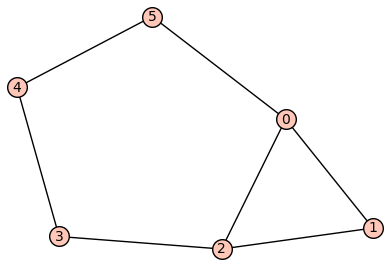

{1,2,3,}, {1,2,3,4,5,}
{3,4,5,}, {3,4,5,}
{1,4,3,}, {1,3,4,5,}
{1,4,5,}, {1,4,5,}
{1,2,4,5,}, {1,2,4,5,}
{0,1,5,}, {0,1,4,5,}
{0,2,3,5,}, {0,2,3,4,5,}
{3,4,2,5,}, {2,3,4,5,}
{0,4,5,3,}, {0,3,4,5,}
{0,1,3,4,}, {0,1,3,4,5,}
{0,1,3,5,}, {0,1,3,5,}


In [17]:
G = graphs.EmptyGraph()
for i in range(0, 5):
    G.add_edge(i, i+1)
G.add_edge(0, 5)
G.add_edge(0, 2)
#G.add_edge(3, 5)
G.show()
extensions = find_extensions(G, 4, 4)
for interval in extensions:
    print(str(interval))

Now that we have the possible neighborhoods for the new vertex, we define a function converting an interval into the graphs it represents.

In [18]:
import itertools

# Adds a vertex to G based on the given interval
# INPUT: a graph G and an interval of corresponding vertices that are viable neighborhoods for a new vertex v
# OUTPUT: a list of graphs that are G with a vertex added
def add_vertex(G, interval):
    
    finished_graphs = []
    bottom = interval.bottom
    top_not_in_bottom = []
    
    # Need the vertices in the top but not the bottom since these determine the different neighborhoods the interval represents
    for vertex in interval.top:
        if not vertex in bottom:
            top_not_in_bottom.append(vertex)
    
    # Recursively finds all ways to add v based on the interval
    # Recurses based on the size of the neighborhood, so it runs len(top_not_in_bottom) + 1 times
    def recursive_search(G, bottom, top_not_in_bottom, neighborhood_size):
        
        #print(bottom, top_not_in_bottom, neighborhood_size)
        
        missing_spots = neighborhood_size - len(bottom)
        
        # Find all possible ways to fill the missing spots in the neighborhood and do so
        for missing_comb in itertools.combinations(top_not_in_bottom, missing_spots):
            
            neighborhood = bottom + list(missing_comb)
            
            new_G = G.copy()
            
            new_G.add_vertex("v")
            
            for vert in neighborhood:
                
                new_G.add_edge("v", vert)
                
            finished_graphs.append(new_G)
            
        # If our current neighborhood isn't the top, we recurse
        if not len(bottom) + len(top_not_in_bottom) == neighborhood_size:
            recursive_search(G, bottom, top_not_in_bottom, neighborhood_size + 1)
    
    # Start with just the bottom of the interval
    recursive_search(G, bottom, top_not_in_bottom, len(bottom))
    
    return finished_graphs

Testing this new function on the previous example. There should be 18 graphs:

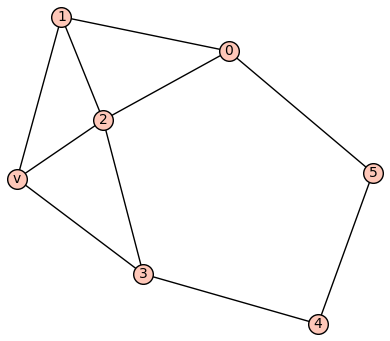

3
3
No J4


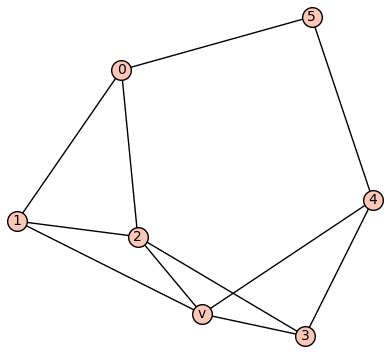

3
3
No J4


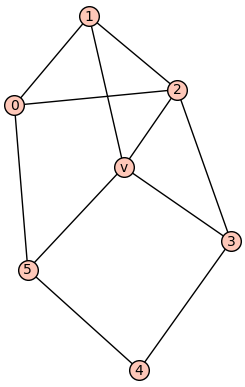

3
3
No J4


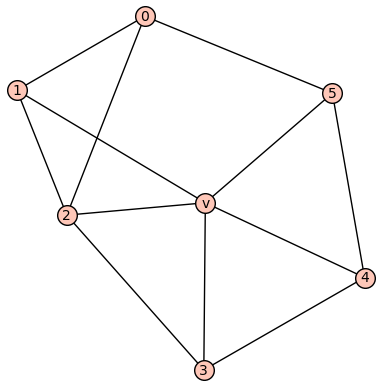

3
3
No J4


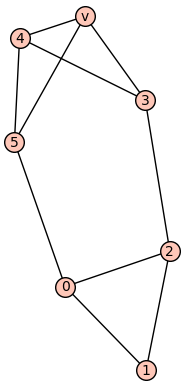

3
3
No J4


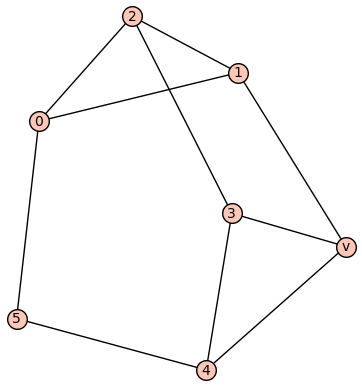

3
3
No J4


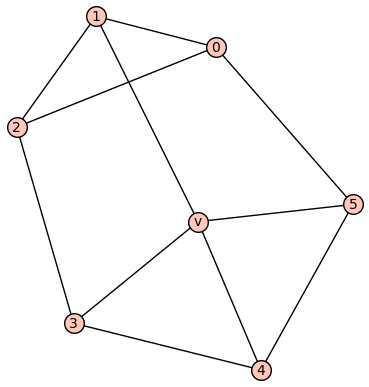

3
3
No J4


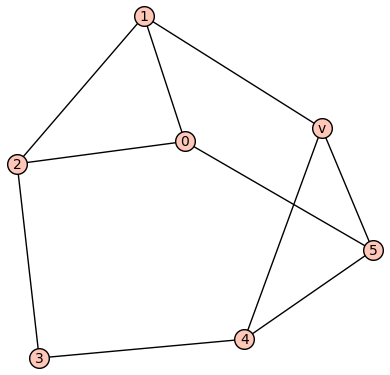

3
3
No J4


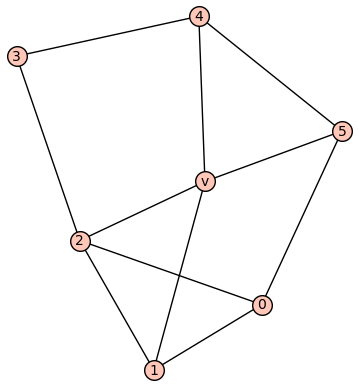

3
3
No J4


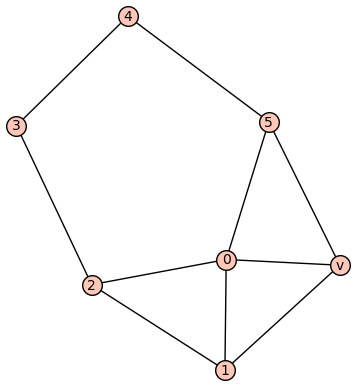

3
3
No J4


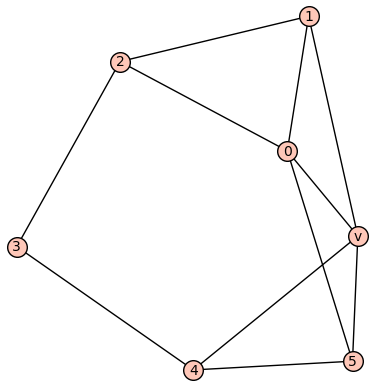

3
3
No J4


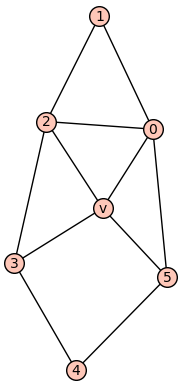

3
3
No J4


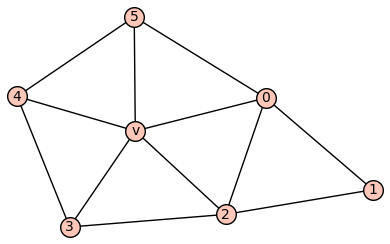

3
3
No J4


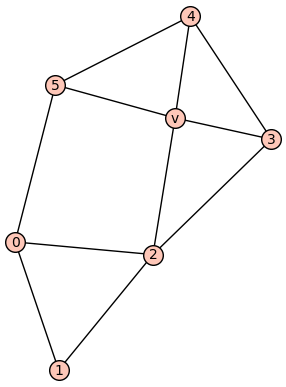

3
3
No J4


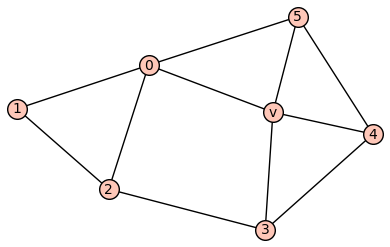

3
3
No J4


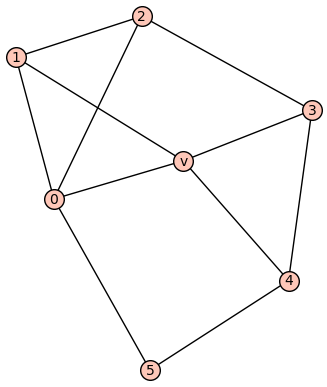

3
3
No J4


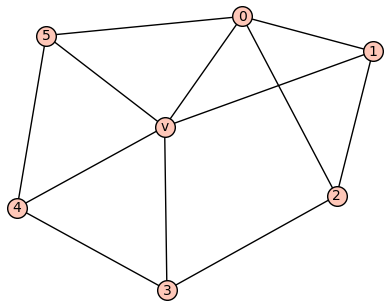

3
3
No J4


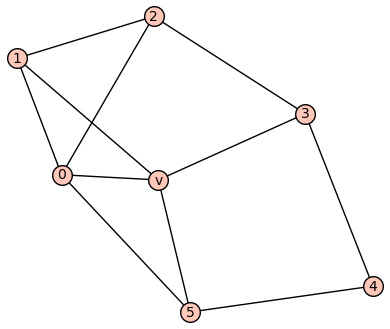

3
3
No J4


In [19]:
extended_graphs = []

for i in range(0, len(extensions)):
    new_graphs = add_vertex(G, extensions[i])

    for graph in new_graphs:
        extended_graphs.append(graph)
        
for graph in extended_graphs:
    graph.show()
    print(graph.clique_number())
    print(graph.complement().clique_number())
    potential_js = itertools.combinations(graph.vertices(sort=False), 4)
    has_j = false
    for j in potential_js:
        numEdges = 0
        for pair in itertools.combinations(j, 2):
            if graph.has_edge(pair[0], pair[1]):
                numEdges += 1
        if numEdges == 1:
            has_j = true
    if has_j:
        print("Contains J4")
    else:
        print("No J4")

Test our functions on some of the known graphs in R(K3, J6). We start with the single order 16 graph and do not expect to find any viable extensions:

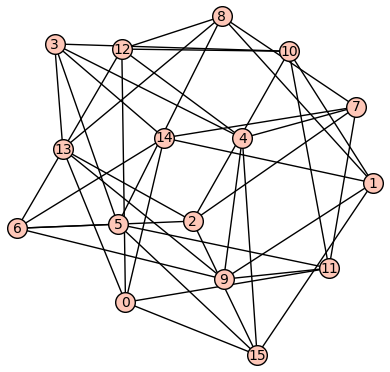

0


In [20]:
from sage.graphs.graph_input import from_graph6

order16_graph = Graph()
with open('k3k6e_16.g6', 'r') as file: # Opens the file, and closes it once we exit this block. 
    imported_graphs = file.readlines() 
    G = Graph()
    from_graph6(G, imported_graphs[0])
    G = G.complement()
    order16_graph = G
    G.show()
    extensions = find_extensions(G, 3, 6)
    print(len(extensions))
    for interval in extensions:
        print(str(interval))

We now test on the order 15 graph. This does find a viable extension, so we check that the corresponding graph does not contain a size 3 clique or an independent J6.

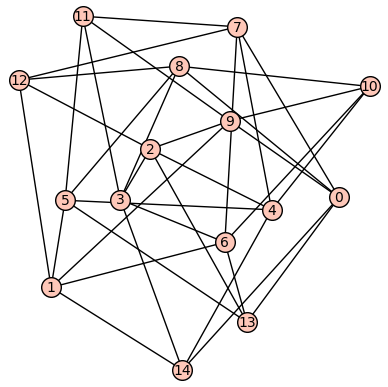

1
{10,11,12,13,14,}, {10,11,12,13,14,}


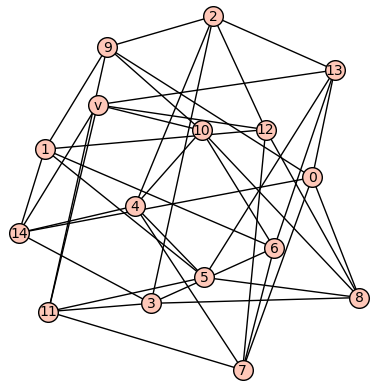

2
5
No J6


In [21]:
extended_graphs = []

order15_graph = Graph()
with open('k3k6e_15.g6', 'r') as file: # Opens the file, and closes it once we exit this block. 
    imported_graphs = file.readlines() 
    G = Graph()
    from_graph6(G, imported_graphs[0])
    G = G.complement()
    order15_graph = G
    G.show()
    extensions = find_extensions(G, 3, 6)
    print(len(extensions))
    for interval in extensions:
        print(str(interval))
        new_graphs = add_vertex(G, interval)
        for graph in new_graphs:
            extended_graphs.append(graph)
            
for graph in extended_graphs:
    graph.show()
    print(graph.clique_number())
    print(graph.complement().clique_number())
    potential_js = itertools.combinations(graph.vertices(sort=False), 6)
    has_j = false
    for j in potential_js:
        numEdges = 0
        for pair in itertools.combinations(j, 2):
            if graph.has_edge(pair[0], pair[1]):
                numEdges += 1
        if numEdges == 1:
            has_j = true
    if has_j:
        print("Contains J6")
    else:
        print("No J6")

We also want to test that the graph we found is isomorphic to the only order 16 graph, otherwise something is wrong. Fortunately, that appears to be the case.

In [22]:
for graph in extended_graphs:
    print(order16_graph.is_isomorphic(graph))

True


Finally, we also test on the order 14 graphs, which gives a couple of viable extensions, so we check that they're isomorphic to the only order 15 graph.

Graph:  0
0
Graph:  1
0
Graph:  2
2
{7,9,11,12,13,}, {7,9,11,12,13,}
{6,8,10,12,13,}, {6,8,10,12,13,}
Graph:  3
2
{6,9,11,12,}, {6,9,11,12,}
{7,8,10,13,}, {7,8,10,13,}


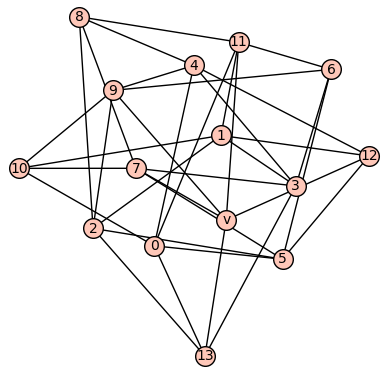

2
5
No J6


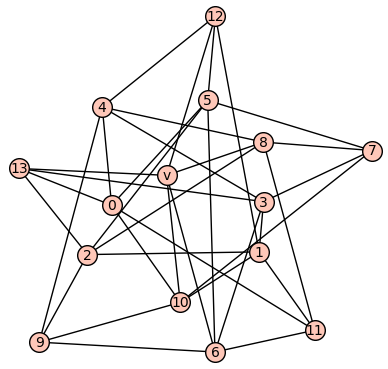

2
5
No J6


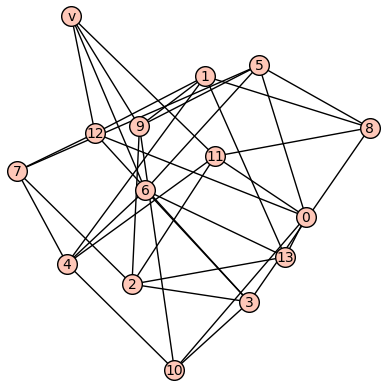

2
5
No J6


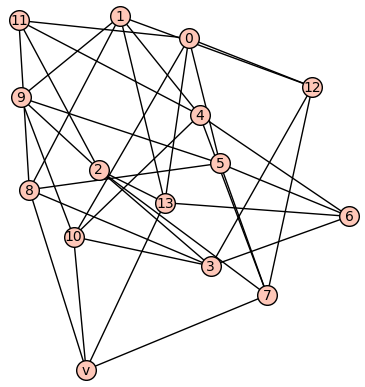

2
5
No J6


In [23]:
extended_graphs = []

with open('k3k6e_14.g6', 'r') as file: # Opens the file, and closes it once we exit this block. 
    imported_graphs = file.readlines()
    for i in range(0, len(imported_graphs)):
        print("Graph: ", i)
        G = Graph()
        from_graph6(G, imported_graphs[i])
        G = G.complement()
#         G.show()
        extensions = find_extensions(G, 3, 6)
        print(len(extensions))
        for interval in extensions:
            print(str(interval))
        if len(extensions) > 0:
            for extension in extensions:
                new_graphs = add_vertex(G, extension)
                for graph in new_graphs:
                    extended_graphs.append(graph)
        
for graph in extended_graphs:
    graph.show()
    print(graph.clique_number())
    print(graph.complement().clique_number())
    potential_js = itertools.combinations(graph.vertices(sort=False), 6)
    has_j = false
    for j in potential_js:
        numEdges = 0
        for pair in itertools.combinations(j, 2):
            if graph.has_edge(pair[0], pair[1]):
                numEdges += 1
        if numEdges == 1:
            has_j = true
    if has_j:
        print("Contains J6")
    else:
        print("No J6")

In [24]:
for graph in extended_graphs:
    print(order15_graph.is_isomorphic(graph))

True
True
True
True


Here we check for extensions on all the successfull order 15 gluings.

In [25]:
extended_graphs = []
num_extensions = 0

with open('15allproblemsiso.g6', 'r') as file: # Opens the file, and closes it once we exit this block. 
    imported_graphs = file.readlines()
    for i in range(0, len(imported_graphs)):
        print("Graph: ", i)
        G = Graph()
        from_graph6(G, imported_graphs[i])
        extensions = find_extensions(G, 4, 6)
        print(len(extensions))
        for interval in extensions:
            print(str(interval))
        if len(extensions) > 0:
            for extension in extensions:
                new_graphs = add_vertex(G, extension)
                for graph in new_graphs:
                    num_extensions += 1

                    
print(num_extensions)

Graph:  0
0
Graph:  1
0
Graph:  2
0
Graph:  3
0
Graph:  4
0
Graph:  5
0
Graph:  6
0
Graph:  7
0
Graph:  8
0
Graph:  9
0
Graph:  10
0
Graph:  11
0
Graph:  12
0
Graph:  13
0
Graph:  14
0
Graph:  15
0
Graph:  16
0
Graph:  17
0
Graph:  18
0
Graph:  19
0
Graph:  20
0
Graph:  21
0
Graph:  22
0
Graph:  23
0
Graph:  24
0
Graph:  25
0
Graph:  26
0
Graph:  27
0
Graph:  28
0
Graph:  29
0
Graph:  30
0
Graph:  31
0
Graph:  32
0
Graph:  33
0
Graph:  34
0
Graph:  35
0
Graph:  36
0
Graph:  37
0
Graph:  38
0
Graph:  39
0
Graph:  40
0
Graph:  41
0
Graph:  42
0
Graph:  43
0
Graph:  44
0
Graph:  45
0
Graph:  46
0
Graph:  47
0
Graph:  48
0
Graph:  49
0
Graph:  50
0
Graph:  51
0
Graph:  52
0
Graph:  53
0
Graph:  54
0
Graph:  55
0
Graph:  56
0
Graph:  57
0
Graph:  58
0
Graph:  59
0
Graph:  60
0
Graph:  61
0
Graph:  62
0
Graph:  63
0
Graph:  64
0
Graph:  65
0
Graph:  66
0
Graph:  67
0
Graph:  68
0
Graph:  69
0
Graph:  70
0
Graph:  71
0
Graph:  72
0
Graph:  73
0
Graph:  74
0
Graph:  75
0
Graph:  76
0
Graph:  7

0
Graph:  594
0
Graph:  595
0
Graph:  596
0
Graph:  597
0
Graph:  598
0
Graph:  599
0
Graph:  600
0
Graph:  601
0
Graph:  602
0
Graph:  603
0
Graph:  604
0
Graph:  605
0
Graph:  606
0
Graph:  607
0
Graph:  608
0
Graph:  609
0
Graph:  610
0
Graph:  611
0
Graph:  612
0
Graph:  613
0
Graph:  614
0
Graph:  615
0
Graph:  616
0
Graph:  617
0
Graph:  618
0
Graph:  619
0
Graph:  620
0
Graph:  621
0
Graph:  622
0
Graph:  623
0
Graph:  624
0
Graph:  625
0
Graph:  626
0
Graph:  627
0
Graph:  628
0
Graph:  629
0
Graph:  630
0
Graph:  631
0
Graph:  632
0
Graph:  633
0
Graph:  634
0
Graph:  635
0
Graph:  636
0
Graph:  637
0
Graph:  638
0
Graph:  639
0
Graph:  640
0
Graph:  641
0
Graph:  642
0
Graph:  643
0
Graph:  644
0
Graph:  645
0
Graph:  646
0
Graph:  647
0
Graph:  648
0
Graph:  649
0
Graph:  650
0
Graph:  651
0
Graph:  652
0
Graph:  653
0
Graph:  654
0
Graph:  655
0
Graph:  656
0
Graph:  657
0
Graph:  658
0
Graph:  659
0
Graph:  660
0
Graph:  661
0
Graph:  662
0
Graph:  663
0
Graph:  664
0
Grap

0
Graph:  1168
0
Graph:  1169
0
Graph:  1170
0
Graph:  1171
0
Graph:  1172
0
Graph:  1173
0
Graph:  1174
0
Graph:  1175
0
Graph:  1176
0
Graph:  1177
0
Graph:  1178
0
Graph:  1179
0
Graph:  1180
0
Graph:  1181
0
Graph:  1182
0
Graph:  1183
0
Graph:  1184
0
Graph:  1185
0
Graph:  1186
0
Graph:  1187
0
Graph:  1188
0
Graph:  1189
0
Graph:  1190
0
Graph:  1191
0
Graph:  1192
0
Graph:  1193
0
Graph:  1194
0
Graph:  1195
0
Graph:  1196
0
Graph:  1197
0
Graph:  1198
0
Graph:  1199
0
Graph:  1200
0
Graph:  1201
0
Graph:  1202
0
Graph:  1203
0
Graph:  1204
0
Graph:  1205
0
Graph:  1206
0
Graph:  1207
0
Graph:  1208
0
Graph:  1209
0
Graph:  1210
0
Graph:  1211
0
Graph:  1212
0
Graph:  1213
0
Graph:  1214
0
Graph:  1215
0
Graph:  1216
0
Graph:  1217
0
Graph:  1218
0
Graph:  1219
0
Graph:  1220
0
Graph:  1221
0
Graph:  1222
0
Graph:  1223
0
Graph:  1224
0
Graph:  1225
0
Graph:  1226
0
Graph:  1227
0
Graph:  1228
0
Graph:  1229
0
Graph:  1230
0
Graph:  1231
0
Graph:  1232
0
Graph:  1233
0
Graph:  

And it does not find any viable extensions!